In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 442kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.62MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.86MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


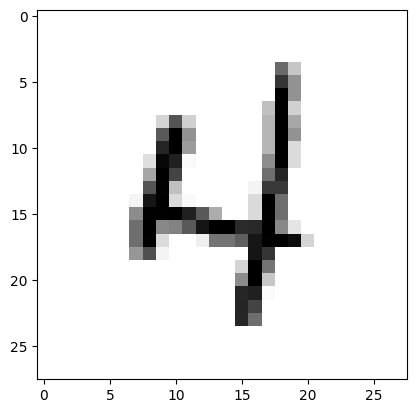

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


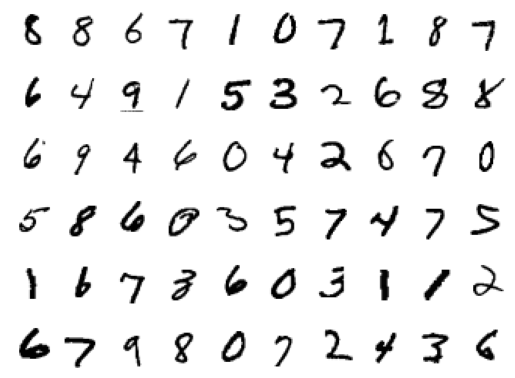

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [ ]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # INPUT 28*28 | OUTPUT 26*26 | RF 3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # INPUT 26*26 | OUTPUT 24*24 | RF 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # INPUT 24*24 | OUTPUT 22*22 | RF 7

        self.pool1 = nn.MaxPool2d(2, 2) # INPUT 22*22 | OUTPUT 11*11 | RF 8

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # INPUT 11*11 | OUTPUT 9*9 | RF 12

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # INPUT 9*9 | OUTPUT 7*7 | RF 16


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # INPUT 7*7 | OUTPUT 5*5 | RF 20

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # INPUT 5*5 | OUTPUT 3*3 | RF 24

        self.gap = nn.Sequential(
            nn.AvgPool2d(3)
        ) # INPUT 3*3 | OUTPUT 1*1 | RF 28

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model1().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,168
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]           1,450
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 20, 9, 9]           1,820
      BatchNorm2d-12             [-1, 20, 9, 9]              40
             ReLU-13             [-1, 20, 9, 9]               0
           Conv2d-14             [

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Model1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1615714132785797 Batch_id=468 Accuracy=94.83: 100%|██████████| 469/469 [00:17<00:00, 27.00it/s]



Test set: Average loss: 0.0809, Accuracy: 9874/10000 (98.74%)

EPOCH: 1


Loss=0.09870464354753494 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]



Test set: Average loss: 0.0598, Accuracy: 9891/10000 (98.91%)

EPOCH: 2


Loss=0.06682561337947845 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:16<00:00, 27.78it/s]



Test set: Average loss: 0.0463, Accuracy: 9896/10000 (98.96%)

EPOCH: 3


Loss=0.03591493144631386 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]



Test set: Average loss: 0.0398, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.01757017709314823 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]



Test set: Average loss: 0.0362, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.021575862541794777 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 28.43it/s]



Test set: Average loss: 0.0314, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.023224657401442528 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]



Test set: Average loss: 0.0316, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.023533277213573456 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]



Test set: Average loss: 0.0260, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.008406040258705616 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]



Test set: Average loss: 0.0306, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.022673368453979492 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:17<00:00, 26.69it/s]



Test set: Average loss: 0.0269, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.02085181511938572 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]



Test set: Average loss: 0.0220, Accuracy: 9946/10000 (99.46%)

EPOCH: 11


Loss=0.02772708795964718 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:20<00:00, 23.41it/s]



Test set: Average loss: 0.0260, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.029824933037161827 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]



Test set: Average loss: 0.0248, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.04310476407408714 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]



Test set: Average loss: 0.0225, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.017283542081713676 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:17<00:00, 27.07it/s]



Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)



**TARGET:**

Make the model lighter

Keep the epochs within 15

Keep the parameters less than 8000

**RESULT:**

Parameters : 9,954

Best Training Accuracy : 99.51

Best Test Accuracy : 99.46

**ANALYSIS:**

Total number of parameters is not less than 8000

The total number of epochs used is 15

The model was good till 1th epoch but from the 11th epoch we could see the model is overfitting

**WHAT CAN BE DONE:**

Change the convolution layers to keep the parameters in check

Introduce dropout to reduce over fitting

In [ ]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

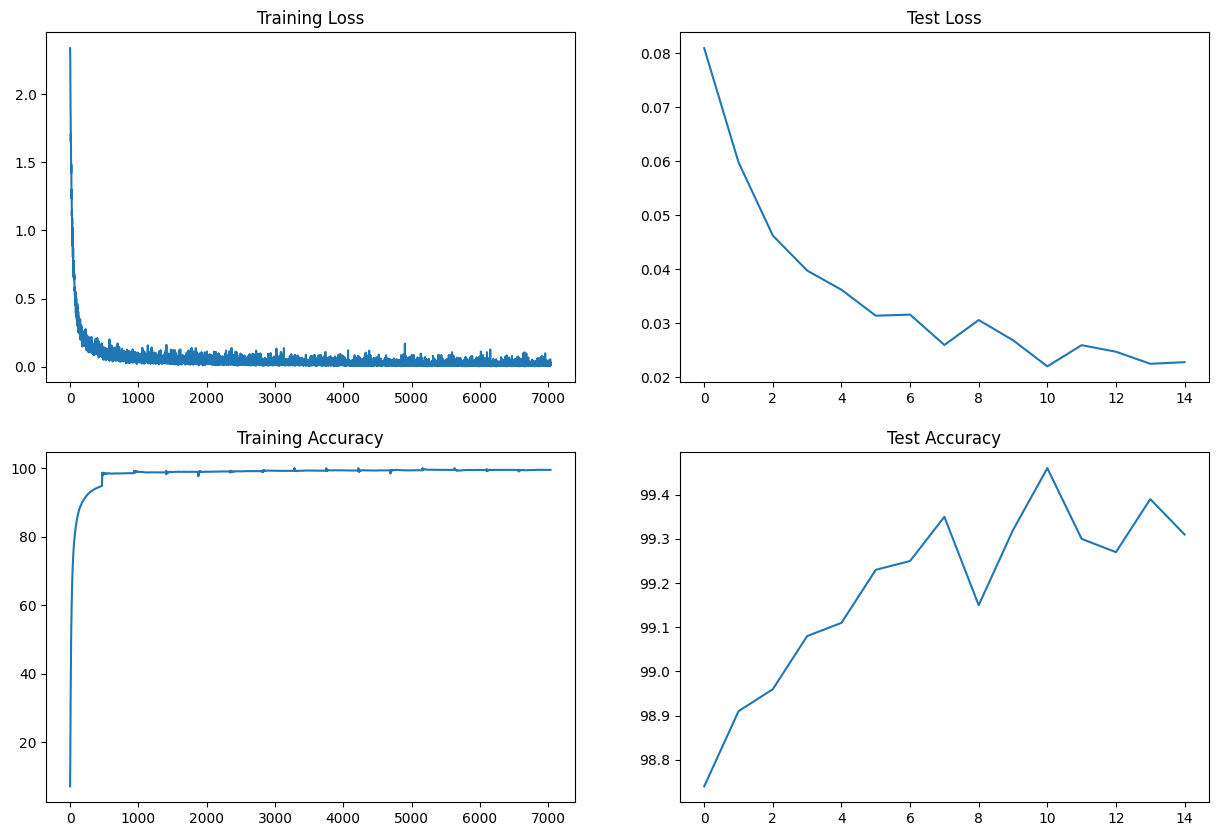

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")